# Zararlı URL Analizi: Malicious URLs Dataset ile Makine Öğrenmesi Uygulamaları

Proje, kötü amaçlı URL'leri analiz etmeyi ve sınıflandırmayı hedefleyen bir makine öğrenimi uygulaması olarak geliştirilmiştir. Bu çalışmada "Malicious URLs Dataset" adlı veri seti kullanılmıştır. Bu veri seti, farklı kategorilere ayrılmış URL'leri içermekte ve makine öğreniminde gözetimli ve gözetimsiz öğrenme tekniklerinin uygulanmasına olanak tanımaktadır.

Proje, veri ön işleme aşamalarını ve çeşitli makine öğrenimi algoritmalarının uygulanmasını içermektedir.




# Veri Setini İnceleyelim

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("/kaggle/input/malicious-urls-dataset/malicious_phish.csv")
df.info()
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB
                                                      url    type
count                                              651191  651191
unique                                             641119       4
top     http://style.org.hc360.com/css/detail/mysite/s...  benign
freq                                                  180  428103
url     0
type    0
dtype: int64


**Null veri yok iki sütunumuz ve 651191 url var.**

# Veri Ön İşleme
**url_type sütununundaki veriler rakamlarla eşlendi ve dataframe'e yeni bir sütun olarak eklendi.**

In [2]:
df["url_type"] = df["type"].replace({
    'benign':0,
    'defacement':1,
    'phishing':2,
    'malware':3
});

/tmp/ipykernel_36/1296184275.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["url_type"] = df["type"].replace({


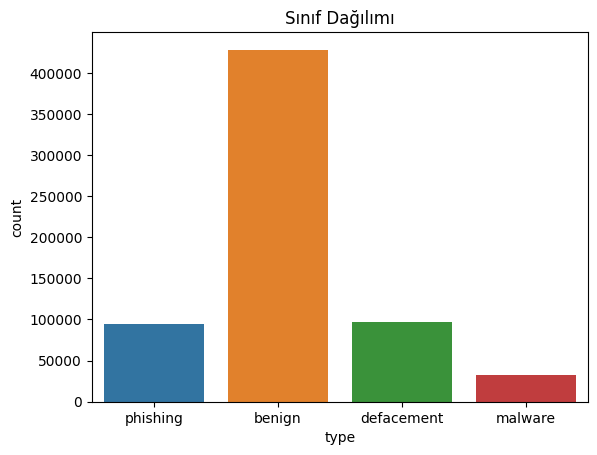

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='type', data=df)
plt.title('Sınıf Dağılımı')
plt.show()

In [4]:
#Baştaki www kısmını sil.
df["url"] = df["url"].replace("www","",regex=True)

df.head

<bound method NDFrame.head of                                                       url        type  \
0                                        br-icloud.com.br    phishing   
1                     mp3raid.com/music/krizz_kaliko.html      benign   
2                         bopsecrets.org/rexroth/cr/1.htm      benign   
3       http://.garage-pirenne.be/index.php?option=com...  defacement   
4       http://adventure-nicaragua.net/index.php?optio...  defacement   
...                                                   ...         ...   
651186            xbox360.ign.com/objects/850/850402.html    phishing   
651187       games.teamxbox.com/xbox-360/1860/Dead-Space/    phishing   
651188            .gamespot.com/xbox360/action/deadspace/    phishing   
651189      en.wikipedia.org/wiki/Dead_Space_(video_game)    phishing   
651190             .angelfire.com/goth/devilmaycrytonite/    phishing   

        url_type  
0              2  
1              0  
2              0  
3              1 

**URL'den ana alan adını ayıran bir fonksiyon yazıldı ve dataframe'e eklendi.**

In [5]:
from urllib.parse import urlparse

def extract_pri_domain(url):
    try:
        parsed_url = urlparse(url)
        netloc = parsed_url.netloc
        parts = netloc.split('.')
        
        if len(parts) >= 2:
            pri_domain = f"{parts[-2]}.{parts[-1]}"
        else:
            pri_domain = None
        
    except Exception as e:
        print(f"An error occurred: {e}")
        pri_domain = None
    
    return pri_domain

In [6]:
df['pri_domain'] = df['url'].apply(extract_pri_domain)
df.isnull().sum()

url                0
type               0
url_type           0
pri_domain    463192
dtype: int64

**Kalan nullar dolduruldu.**

In [7]:
df.fillna('0',inplace=True)
df.isnull().sum()

url           0
type          0
url_type      0
pri_domain    0
dtype: int64

**URL'deki temel anormallikleri kontrol eden bir fonksiyon**:

In [8]:
from urllib.parse import urlparse

def abnormal_url(url):
    parsed_url = urlparse(url)
    netloc = parsed_url.netloc
    
    if netloc and netloc in url:
        return 1
    return 0
df['abnormal_url'] = df['url'].apply(abnormal_url)   

<Axes: xlabel='type', ylabel='count'>

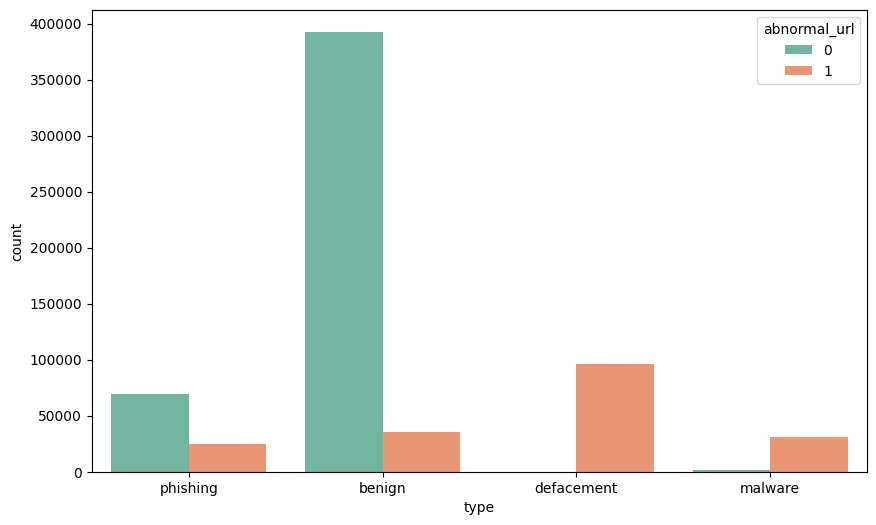

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='type', hue='abnormal_url', palette='Set2')

**Her bir Url'deki harf rakam ve özel karakter sayıları belirlendi ve dataframe'e eklendi**.

In [10]:
def count_letters(url):
    return sum(char.isalpha() for char in url)

def count_digits(url):
    return sum(char.isdigit() for char in url)

import string

def count_special_chars(url):
    return sum(char in string.punctuation for char in url)

In [11]:
df['letters_count'] = df['url'].apply(count_letters)
df['digits_count'] = df['url'].apply(count_digits)
df['special_chars_count'] = df['url'].apply(count_special_chars)

**Veri setindeki URL'lerin sonundaki uzantılar analiz edilerek, her bir uzantı sınıflandırıldı. Bu işlem, URL'lerin türlerini belirlemek ve modelin doğruluk oranını arttırmak için önemli**.

In [12]:
def get_url_region(primary_domain):
    ccTLD_to_region = {
        ".ac": "Ascension Island",
        ".ad": "Andorra",
        ".ae": "United Arab Emirates",
        ".af": "Afghanistan",
        ".ag": "Antigua and Barbuda",
        ".ai": "Anguilla",
        ".al": "Albania",
        ".am": "Armenia",
        ".an": "Netherlands Antilles",
        ".ao": "Angola",
        ".aq": "Antarctica",
        ".ar": "Argentina",
        ".as": "American Samoa",
        ".at": "Austria",
        ".au": "Australia",
        ".aw": "Aruba",
        ".ax": "Åland Islands",
        ".az": "Azerbaijan",
        ".ba": "Bosnia and Herzegovina",
        ".bb": "Barbados",
        ".bd": "Bangladesh",
        ".be": "Belgium",
        ".bf": "Burkina Faso",
        ".bg": "Bulgaria",
        ".bh": "Bahrain",
        ".bi": "Burundi",
        ".bj": "Benin",
        ".bm": "Bermuda",
        ".bn": "Brunei Darussalam",
        ".bo": "Bolivia",
        ".br": "Brazil",
        ".bs": "Bahamas",
        ".bt": "Bhutan",
        ".bv": "Bouvet Island",
        ".bw": "Botswana",
        ".by": "Belarus",
        ".bz": "Belize",
        ".ca": "Canada",
        ".cc": "Cocos Islands",
        ".cd": "Democratic Republic of the Congo",
        ".cf": "Central African Republic",
        ".cg": "Republic of the Congo",
        ".ch": "Switzerland",
        ".ci": "Côte d'Ivoire",
        ".ck": "Cook Islands",
        ".cl": "Chile",
        ".cm": "Cameroon",
        ".cn": "China",
        ".co": "Colombia",
        ".cr": "Costa Rica",
        ".cu": "Cuba",
        ".cv": "Cape Verde",
        ".cw": "Curaçao",
        ".cx": "Christmas Island",
        ".cy": "Cyprus",
        ".cz": "Czech Republic",
        ".de": "Germany",
        ".dj": "Djibouti",
        ".dk": "Denmark",
        ".dm": "Dominica",
        ".do": "Dominican Republic",
        ".dz": "Algeria",
        ".ec": "Ecuador",
        ".ee": "Estonia",
        ".eg": "Egypt",
        ".er": "Eritrea",
        ".es": "Spain",
        ".et": "Ethiopia",
        ".eu": "European Union",
        ".fi": "Finland",
        ".fj": "Fiji",
        ".fk": "Falkland Islands",
        ".fm": "Federated States of Micronesia",
        ".fo": "Faroe Islands",
        ".fr": "France",
        ".ga": "Gabon",
        ".gb": "United Kingdom",
        ".gd": "Grenada",
        ".ge": "Georgia",
        ".gf": "French Guiana",
        ".gg": "Guernsey",
        ".gh": "Ghana",
        ".gi": "Gibraltar",
        ".gl": "Greenland",
        ".gm": "Gambia",
        ".gn": "Guinea",
        ".gp": "Guadeloupe",
        ".gq": "Equatorial Guinea",
        ".gr": "Greece",
        ".gs": "South Georgia and the South Sandwich Islands",
        ".gt": "Guatemala",
        ".gu": "Guam",
        ".gw": "Guinea-Bissau",
        ".gy": "Guyana",
        ".hk": "Hong Kong",
        ".hm": "Heard Island and McDonald Islands",
        ".hn": "Honduras",
        ".hr": "Croatia",
        ".ht": "Haiti",
        ".hu": "Hungary",
        ".id": "Indonesia",
        ".ie": "Ireland",
        ".il": "Israel",
        ".im": "Isle of Man",
        ".in": "India",
        ".io": "British Indian Ocean Territory",
        ".iq": "Iraq",
        ".ir": "Iran",
        ".is": "Iceland",
        ".it": "Italy",
        ".je": "Jersey",
        ".jm": "Jamaica",
        ".jo": "Jordan",
        ".jp": "Japan",
        ".ke": "Kenya",
        ".kg": "Kyrgyzstan",
        ".kh": "Cambodia",
        ".ki": "Kiribati",
        ".km": "Comoros",
        ".kn": "Saint Kitts and Nevis",
        ".kp": "Democratic People's Republic of Korea (North Korea)",
        ".kr": "Republic of Korea (South Korea)",
        ".kw": "Kuwait",
        ".ky": "Cayman Islands",
        ".kz": "Kazakhstan",
        ".la": "Laos",
        ".lb": "Lebanon",
        ".lc": "Saint Lucia",
        ".li": "Liechtenstein",
        ".lk": "Sri Lanka",
        ".lr": "Liberia",
        ".ls": "Lesotho",
        ".lt": "Lithuania",
        ".lu": "Luxembourg",
        ".lv": "Latvia",
        ".ly": "Libya",
        ".ma": "Morocco",
        ".mc": "Monaco",
        ".md": "Moldova",
        ".me": "Montenegro",
        ".mf": "Saint Martin (French part)",
        ".mg": "Madagascar",
        ".mh": "Marshall Islands",
        ".mk": "North Macedonia",
        ".ml": "Mali",
        ".mm": "Myanmar",
        ".mn": "Mongolia",
        ".mo": "Macao",
        ".mp": "Northern Mariana Islands",
        ".mq": "Martinique",
        ".mr": "Mauritania",
        ".ms": "Montserrat",
        ".mt": "Malta",
        ".mu": "Mauritius",
        ".mv": "Maldives",
        ".mw": "Malawi",
        ".mx": "Mexico",
        ".my": "Malaysia",
        ".mz": "Mozambique",
        ".na": "Namibia",
        ".nc": "New Caledonia",
        ".ne": "Niger",
        ".nf": "Norfolk Island",
        ".ng": "Nigeria",
        ".ni": "Nicaragua",
        ".nl": "Netherlands",
        ".no": "Norway",
        ".np": "Nepal",
        ".nr": "Nauru",
        ".nu": "Niue",
        ".nz": "New Zealand",
        ".om": "Oman",
        ".pa": "Panama",
        ".pe": "Peru",
        ".pf": "French Polynesia",
        ".pg": "Papua New Guinea",
        ".ph": "Philippines",
        ".pk": "Pakistan",
        ".pl": "Poland",
        ".pm": "Saint Pierre and Miquelon",
        ".pn": "Pitcairn",
        ".pr": "Puerto Rico",
        ".ps": "Palestinian Territory",
        ".pt": "Portugal",
        ".pw": "Palau",
        ".py": "Paraguay",
        ".qa": "Qatar",
        ".re": "Réunion",
        ".ro": "Romania",
        ".rs": "Serbia",
        ".ru": "Russia",
        ".rw": "Rwanda",
        ".sa": "Saudi Arabia",
        ".sb": "Solomon Islands",
        ".sc": "Seychelles",
        ".sd": "Sudan",
        ".se": "Sweden",
        ".sg": "Singapore",
        ".sh": "Saint Helena",
        ".si": "Slovenia",
        ".sj": "Svalbard and Jan Mayen",
        ".sk": "Slovakia",
        ".sl": "Sierra Leone",
        ".sm": "San Marino",
        ".sn": "Senegal",
        ".so": "Somalia",
        ".sr": "Suriname",
        ".ss": "South Sudan",
        ".st": "São Tomé and Príncipe",
        ".sv": "El Salvador",
        ".sx": "Sint Maarten (Dutch part)",
        ".sy": "Syria",
        ".sz": "Eswatini",
        ".tc": "Turks and Caicos Islands",
        ".td": "Chad",
        ".tf": "French Southern Territories",
        ".tg": "Togo",
        ".th": "Thailand",
        ".tj": "Tajikistan",
        ".tk": "Tokelau",
        ".tl": "Timor-Leste",
        ".tm": "Turkmenistan",
        ".tn": "Tunisia",
        ".to": "Tonga",
        ".tr": "Turkey",
        ".tt": "Trinidad and Tobago",
        ".tv": "Tuvalu",
        ".tw": "Taiwan",
        ".tz": "Tanzania",
        ".ua": "Ukraine",
        ".ug": "Uganda",
        ".uk": "United Kingdom",
        ".us": "United States",
        ".uy": "Uruguay",
        ".uz": "Uzbekistan",
        ".va": "Vatican City",
        ".vc": "Saint Vincent and the Grenadines",
        ".ve": "Venezuela",
        ".vg": "British Virgin Islands",
        ".vi": "U.S. Virgin Islands",
        ".vn": "Vietnam",
        ".vu": "Vanuatu",
        ".wf": "Wallis and Futuna",
        ".ws": "Samoa",
        ".ye": "Yemen",
        ".yt": "Mayotte",
        ".za": "South Africa",
        ".zm": "Zambia",
        ".zw": "Zimbabwe"
    }   
    sorted_tld_keys = sorted(ccTLD_to_region.keys(), key=len, reverse=True)
    
    for ccTLD in sorted_tld_keys:
        if primary_domain.lower().endswith(ccTLD):
            return ccTLD_to_region[ccTLD]
    
    return "Global"

In [13]:
df['url_region'] = df['pri_domain'].apply(get_url_region)

## HTTPS Bağlantısının Kontrolü

**HTTPS, verilerin güvenli bir şekilde iletilmesini sağladığı için önemli bir kriterdir. Bu da modelin performansını arttıracağı için sütunlara eklendi**.

In [14]:
def is_http_secure(url):
    return int(urlparse(url).scheme == 'https')

In [15]:
df['is_http_secure'] = df['url'].apply(is_http_secure)

## URL Kök Alan Adının Sütun Haline Getirilmesi

**Veri setindeki URL'lerden kök alan adını çıkarmak için bir sütun eklendi. Bu işlem, analizleri daha anlamlı hale getirmek ve model için önemli özellikler elde etmek amacıyla yapıldı**.

In [16]:
def extract_root_domain(url):
    try:
        parsed_url = urlparse(url)
        netloc = parsed_url.netloc if parsed_url.netloc else url.split('/')[0]  # Eğer netloc boşsa, ilk kısmı al
        parts = netloc.split('.')
        if len(parts) >= 2:
            root_domain = f"{parts[-2]}.{parts[-1]}"
        else:
            root_domain = "0"
    except Exception as e:
        print(f"An error occurred: {e}")
        root_domain = "0"
    return root_domain

In [17]:
df['root_domain'] = df['url'].apply(extract_root_domain)

In [18]:
print(df['root_domain'])

0                          com.br
1                     mp3raid.com
2                  bopsecrets.org
3               garage-pirenne.be
4         adventure-nicaragua.net
                   ...           
651186                    ign.com
651187               teamxbox.com
651188               gamespot.com
651189              wikipedia.org
651190              angelfire.com
Name: root_domain, Length: 651191, dtype: object


In [19]:
#Tekrarlayan satır kontrolü
df.duplicated().sum()
#Sıfır olanları almadık
df = df[df['root_domain'] != '0']
df['root_domain'].value_counts()
df.drop_duplicates(inplace=True)

/tmp/ipykernel_36/4241115399.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)


In [20]:
import hashlib
def hash_encode(category: str, bits: int = 24) -> int:
    hash_object = hashlib.md5(category.encode())
    hash_value = int(hash_object.hexdigest(), 16)
    return hash_value % (1 << bits)

In [21]:
print(df['root_domain'].unique())
print(df['url_region'].unique())

['com.br' 'mp3raid.com' 'bopsecrets.org' ... 'gamechronicles.com'
 'vggen.com' 'xboxaddict.com']
['Global' 'Belgium' 'Netherlands' 'Germany' 'Hungary' 'Colombia' 'Italy'
 'United Kingdom' 'Brazil' 'Iran' 'Poland' 'Greece' 'Russia' 'Ukraine'
 'Vietnam' 'Romania' 'Chile' 'Argentina' 'Canada' 'Slovakia' 'Spain'
 'Slovenia' 'Cocos Islands' 'Austria' 'Tuvalu' 'European Union' 'China'
 'Malaysia' 'Czech Republic' 'Australia' 'Japan' 'Denmark' 'France'
 'South Africa' 'Lithuania' 'Moldova' 'Finland' 'Indonesia' 'Turkey'
 'India' 'Sweden' 'Switzerland' 'Estonia' 'Singapore' 'United States'
 'Philippines' 'Mexico' 'Republic of Korea (South Korea)' 'Thailand'
 'Norway' 'Portugal' 'Zimbabwe' 'Ireland' 'New Zealand' 'Kazakhstan'
 'Niue' 'Iceland' 'Luxembourg' 'Peru' 'Serbia' 'Cyprus' 'Uzbekistan'
 'Pakistan' 'Bosnia and Herzegovina' 'Bolivia' 'Cape Verde'
 'British Indian Ocean Territory' 'Tonga' 'Azerbaijan' 'Taiwan'
 'Isle of Man' 'Georgia' 'Israel' 'Hong Kong' 'Costa Rica' 'Tokelau'
 'Montenegr

In [22]:
df['root_domain'] = df['root_domain'].apply(hash_encode)
df['url_region'] = df['url_region'].apply(hash_encode)

/tmp/ipykernel_36/1979743194.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['root_domain'] = df['root_domain'].apply(hash_encode)
/tmp/ipykernel_36/1979743194.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['url_region'] = df['url_region'].apply(hash_encode)


In [23]:
df = df.drop(columns=["url", "pri_domain","type"])
df.head()

,url_type,abnormal_url,letters_count,digits_count,special_chars_count,url_region,is_http_secure,root_domain
0,2,0,13,0,3,6617800,0,1711358
1,0,0,29,1,5,6617800,0,4090175
2,0,0,25,1,5,6617800,0,13299758
3,1,1,60,7,18,410023,0,7849850
4,1,1,199,22,14,6617800,0,7752359


# Model Oluşturma: Random Forest

**Veri setini daha kullanışlı hale getirdikten sonra, gözetimli öğrenme algoritmalarından biri olan Random Forest (Rastgele Ormanlar) ile model eğitildi. Random Forest, birden fazla karar ağacını bir araya getirerek daha güçlü ve genelleme yeteneği yüksek bir model oluşturur**.

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

x = df.drop(columns=['url_type']) 
y = df['url_type']  

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Standartlaştırma
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Model
model = RandomForestClassifier(class_weight='balanced',n_estimators=100, random_state=42)
# Eğitim
model.fit(x_train_scaled, y_train)
# Test seti üstünde tahmin
y_pred = model.predict(x_test_scaled)

## KMeans Kümeleme Analizi

### Amaç
**Bu bölümde, veri kümesindeki benzer örnekleri gruplamak için KMeans kümeleme algoritması kullanarak verilerimizi analiz ediyoruz**.

### Veri Hazırlığı
**Veri kümesinden `url_type` sütunu çıkarılarak, kümeleme işlemi için kullanılacak olan özellikler hazırlandı**.


In [25]:
x_unsupervised = df.drop(columns=['url_type'])

## PCA ile Boyut Azaltma

**Kümeleme öncesinde, verinin boyutunu azaltmak için PCA (Principal Component Analysis) uygulandı. Bu, modelin daha hızlı çalışmasını ve görselleştirmenin daha kolay olmasını sağladı**.

In [26]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.utils import resample
from joblib import Parallel, delayed
import numpy as np


scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_unsupervised)

# Örnekleme
x_sample = resample(x_scaled, n_samples=10000, random_state=42)

# PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_sample)

# Kmeans
kmeans = KMeans(n_clusters=3,n_init='auto', random_state=42)
clusters = kmeans.fit_predict(x_pca)


# Model Değerlendirme

## Random Forest

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Performans metrikleri
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Karışıklık matrisi
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Accuracy: 0.9009757353113227
Precision: 0.897792050935436
Recall: 0.9009757353113227
F1 Score: 0.8989708919643451
[[81065   222  4312    56]
 [  167 18333   422    37]
 [ 5548  1155 12007   175]
 [  133   161   308  4110]]


**Modelin genel performansını ve çalışma durumunu gözlemlemek için Cross Validationa sokuyoruz.**

In [28]:
from sklearn.model_selection import cross_val_score

print(df['url_type'].value_counts())
scores = cross_val_score(model, x_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {scores.mean()}")

url_type
0    428071
1     95308
2     94030
3     23645
Name: count, dtype: int64
Cross-validation accuracy: 0.8993727117894522


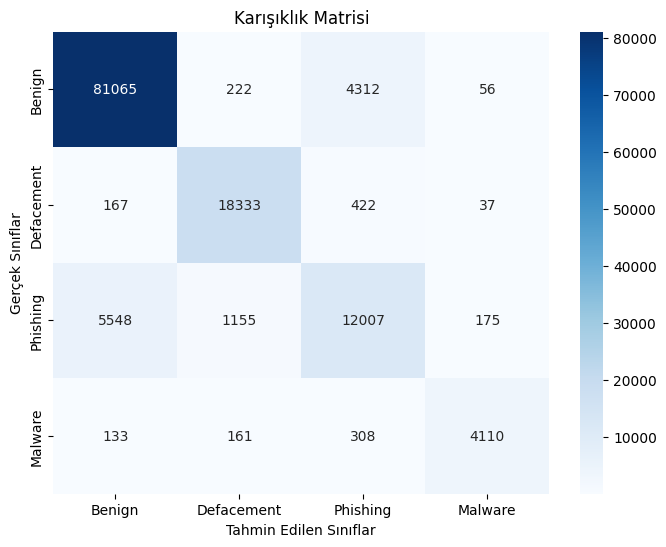

In [29]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Defacement', 'Phishing', 'Malware'], 
            yticklabels=['Benign', 'Defacement', 'Phishing', 'Malware'])
plt.xlabel('Tahmin Edilen Sınıflar')
plt.ylabel('Gerçek Sınıflar')
plt.title('Karışıklık Matrisi')
plt.show()

## K-Means

### Silhouette Skoru Hesaplama

**Silhouette skoru, her bir örneğin kendi kümesindeki diğer örneklerle olan benzerliğini değerlendirir. Daha yüksek silhouette skoru, daha iyi bir kümeleme kalitesine işaret eder.**

In [30]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Silhouette Skoru hesaplama fonksiyonu
def compute_silhouette_score(data, n_clusters):
    model = KMeans(n_clusters=n_clusters,n_init='auto', random_state=42)
    labels = model.fit_predict(data)
    score = silhouette_score(data, labels)
    return score

k_values = range(2, 11)
scores = Parallel(n_jobs=-1)(delayed(compute_silhouette_score)(x_pca, k) for k in k_values)

# Silhouette skorlarını yazdırma
for k, score in zip(k_values, scores):
    print(f'Küme Sayısı: {k}, Silhouette Skoru: {score}')


Küme Sayısı: 2, Silhouette Skoru: 0.5991272564152627
Küme Sayısı: 3, Silhouette Skoru: 0.6178922124066818
Küme Sayısı: 4, Silhouette Skoru: 0.5922116144498357
Küme Sayısı: 5, Silhouette Skoru: 0.5059241171932557
Küme Sayısı: 6, Silhouette Skoru: 0.4672163796268732
Küme Sayısı: 7, Silhouette Skoru: 0.4577615916719009
Küme Sayısı: 8, Silhouette Skoru: 0.4587745595839913
Küme Sayısı: 9, Silhouette Skoru: 0.4393605391832515
Küme Sayısı: 10, Silhouette Skoru: 0.45773210789005025


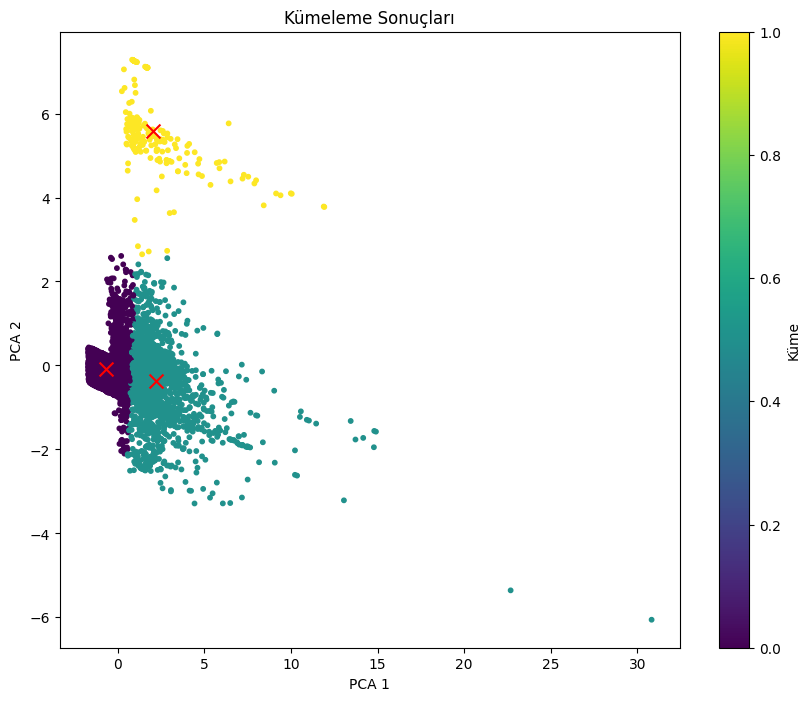

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=clusters, cmap='viridis', s=10)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=100, marker='x')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Kümeleme Sonuçları')
plt.colorbar(label='Küme')
plt.show()

### Elbow Method:

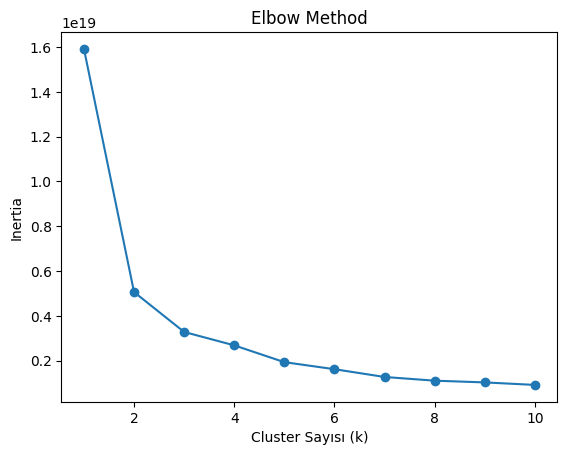

In [32]:
inertia = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(x_unsupervised)
    inertia.append(kmeans.inertia_)
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Cluster Sayısı (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

### Küme Boyutları:

In [33]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
cluster_sizes = dict(zip(unique, counts))
print(f"Küme Boyutları: {cluster_sizes}")

Küme Boyutları: {0: 97617, 1: 68893, 2: 92660, 3: 97684, 4: 6831, 5: 17837, 6: 65781, 7: 79410, 8: 11029, 9: 103312}
